In [1]:
import numpy as np 
import pandas as pd 
import os
#from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D,Input,UpSampling2D, Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, Conv2DTranspose, Layer, LeakyReLU
from tensorflow.keras.losses import binary_crossentropy, sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
import keras.backend as K
import tensorflow as tf
#from tensorflow.keras import metrics

from sklearn.metrics import f1_score, classification_report

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
import random
# to ignore displaying warnings
import warnings
warnings.filterwarnings("ignore")

2022-08-06 17:32:16.209100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-06 17:32:16.209126: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#!pip install opencv-python
#!pip install matplotlib

In [3]:
!ls '../../data/chest_xray/chest_xray'

test  train  val


In [4]:
train_path = "../../data/chest_xray/chest_xray/train"
test_path = "../../data/chest_xray/chest_xray/test"
val_path = "../../data/chest_xray/chest_xray/val"

def displayer(X_tr, X_tr_ae):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(X_tr[i].reshape(64, 64, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(X_tr_ae[i].reshape(64, 64,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Load dataset

In [5]:
dsize =(64, 64)

labels = {"NORMAL":0, "PNEUMONIA":1}

In [6]:
def load_images(dir_path, labels, dsize = (32, 32)):
    """loading images"""
    X_image, y_image = [], []
    for label_name, Id in labels.items():
        for jpeg in tqdm(os.listdir(os.path.join(dir_path, label_name))):
            path = os.path.join(dir_path, label_name, jpeg)
            image = load_img(path, target_size=dsize)
            X_image.append(image)
            #self.X_image.append(img_to_array(image)/255.0)
            y_image.append(Id)
    return X_image, y_image

def display_images(X, y, figure_row=4, figure_cols=4):
    """Display images """
    f, ax = plt.subplots(nrows= figure_row, ncols=figure_cols, 
                         figsize=(figure_row*figure_cols, figure_row*figure_cols)) 
    number_of_images = figure_row * figure_cols
    img = []
    for i in range(figure_row):
        for j in range(figure_cols):
            while True:
                rand = np.random.randint(0, len(X)-1)
                if rand not in img:
                    img.append(rand)
                    break
            image=X[rand]#cv2.imread(self.path_lsts[rand])
            ax[i, j].imshow(image, resample=True, cmap='gray')
            ax[i, j].set_title("Class-"+ str(y[rand]), fontsize=16)
    plt.tight_layout()
    plt.show()
    print

In [7]:
X_train_org, y_train = load_images(train_path, labels, dsize = dsize)

X_test_org, y_test = load_images(test_path, labels, dsize = dsize)

X_val_org, y_val = load_images(val_path, labels, dsize = dsize)

100%|██████████| 8/8 [00:00<00:00, 419.11it/s]


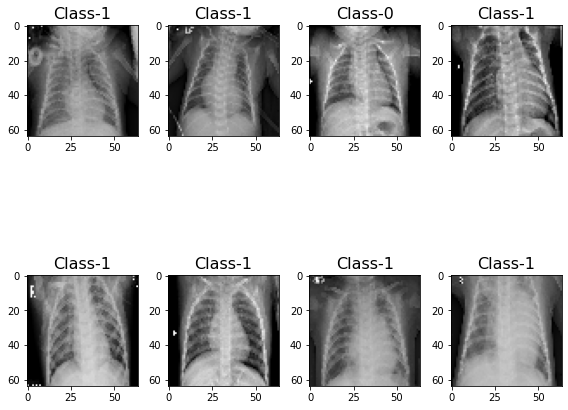

In [8]:
display_images(X_train_org, y_train, figure_row=2, figure_cols=4)

# Preprocessing

In [9]:
def preprocess_images(images, y, normalize = True):
    X = []
    for i in tqdm(range(len(images))):
        img = img_to_array(images[i]).astype('float32')
        if normalize:
            img = img/255.0
        X.append(img)
    #Shuffle data
    dataset = list(zip(X, y))
    random.shuffle(dataset)

    X, y = zip(*dataset)
    return np.array(X), np.array(y)

In [10]:
normalize = True

X_train, y_train =preprocess_images(X_train_org, y_train, normalize=normalize)
print("Shape of X_train:", X_train.shape)

X_val, y_val =preprocess_images(X_val_org, y_val, normalize=normalize)
print("Shape of X_val:", X_val.shape)

X_test, y_test =preprocess_images(X_test_org, y_test, normalize=normalize)
print("Shape of X_test:", X_test.shape)

100%|██████████| 624/624 [00:00<00:00, 18668.21it/s]

Shape of X_train: (5216, 64, 64, 3)
Shape of X_val: (16, 64, 64, 3)
Shape of X_test: (624, 64, 64, 3)


# CNN example

In [4]:
def CNN(num_classes=2, input_shape=(64,64,3)):
    model = Sequential()
    model.add(Conv2D(16, (8, 8),padding='valid', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))
    
    model.add(Conv2D(32, (8, 8), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
    
    model.add(Conv2D(64, (8, 8), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    return model

In [19]:
model = CNN()

model.build(input_shape=(X_train[0].shape))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 57, 57, 16)        3088      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          131136    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

2022-05-27 20:58:47.944235: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-27 20:58:47.944276: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-05-27 20:58:47.944883: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model.fit(X_train,  y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 5s 23ms/step - loss: 0.3689 - accuracy: 0.8409 - val_loss: 0.2986 - val_accuracy: 0.8750
Epoch 2/10
163/163 [==============================] - 3s 20ms/step - loss: 0.1292 - accuracy: 0.9515 - val_loss: 0.3304 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1004 - accuracy: 0.9628 - val_loss: 0.1488 - val_accuracy: 1.0000
Epoch 4/10
163/163 [==============================] - 3s 19ms/step - loss: 0.0931 - accuracy: 0.9680 - val_loss: 0.2298 - val_accuracy: 0.9375
Epoch 5/10
163/163 [==============================] - 3s 19ms/step - loss: 0.0755 - accuracy: 0.9712 - val_loss: 0.5781 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 3s 19ms/step - loss: 0.0718 - accuracy: 0.9732 - val_loss: 0.1081 - val_accuracy: 1.0000
Epoch 7/10
163/163 [==============================] - 3s 19ms/step - loss: 0.0648 - accuracy: 0.9760 - val_loss: 0.2160 - val_accuracy: 0.8750

In [21]:
loss, acc = model.evaluate(X_train, y_train)
print("Train loss:{}, Train Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_val, y_val)
print("Val loss:{}, Val Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_test, y_test)
print("Test loss:{}, Test Accuracy:{}".format(loss, acc))

163/163 [==============================] - 1s 4ms/step - loss: 0.0365 - accuracy: 0.9881
Train loss:0.03648737818002701, Train Accuracy:0.988113522529602
1/1 [==============================] - 0s 17ms/step - loss: 0.3789 - accuracy: 0.8750
Val loss:0.37887078523635864, Val Accuracy:0.875
20/20 [==============================] - 0s 4ms/step - loss: 0.9467 - accuracy: 0.7869
Test loss:0.9466586709022522, Test Accuracy:0.7868589758872986


# Undercompleted autoencoder
https://www.jeremyjordan.me/autoencoders/

In [11]:
def CNNUAE(input_shape):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (8, 8), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(16, (8, 8), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (8, 8), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (8, 8), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(16, (8, 8), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (8, 8), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(3, (8, 8), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

In [12]:
cnnuae_autoencoder = CNNUAE(X_train[0].shape)
cnnuae_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        6176      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        32784     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 16)       64    

2022-08-06 17:32:53.082797: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-06 17:32:53.082825: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (iotg): /proc/driver/nvidia/version does not exist
2022-08-06 17:32:53.083037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
%%time
history = cnnuae_autoencoder.fit(X_train, X_train, epochs=5, batch_size=64,
                    shuffle=True, validation_data=(X_val, X_val))

Epoch 1/5
82/82 [==============================] - 70s 844ms/step - loss: 0.0179 - val_loss: 0.0455
Epoch 2/5
82/82 [==============================] - 69s 836ms/step - loss: 0.0084 - val_loss: 0.0331
Epoch 3/5
82/82 [==============================] - 68s 830ms/step - loss: 0.0070 - val_loss: 0.0230
Epoch 4/5
82/82 [==============================] - 67s 816ms/step - loss: 0.0063 - val_loss: 0.0136
Epoch 5/5
82/82 [==============================] - 69s 838ms/step - loss: 0.0059 - val_loss: 0.0076
CPU times: user 48min 12s, sys: 1min 33s, total: 49min 46s
Wall time: 5min 42s


In [17]:
test_x_predictions = cnnuae_autoencoder.predict(X_test)
train_loss = tf.keras.losses.mae(test_x_predictions, X_test)

In [21]:
loss_threshold = np.percentile(train_loss, 98)
loss_threshold

0.22419660568237293

In [24]:
# Making the Confusion Matrix 
from sklearn.metrics import confusion_matrix 

cm = confusion_matrix(y_test, test_x_predictions) 

cm 

ValueError: Classification metrics can't handle a mix of binary and unknown targets

ValueError: x must have 2 or fewer dimensions

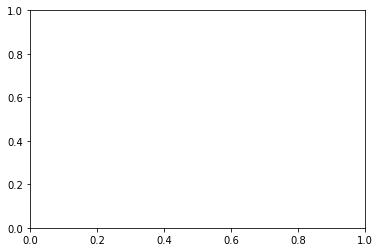

In [18]:
plt.hist(train_loss, bins=50)

In [16]:
error_df_test = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})

ValueError: Data must be 1-dimensional

In [14]:
import itertools
from collections.abc import Iterable
import numpy as np
from bokeh.io import export_svgs
from bokeh.plotting import figure, show
from bokeh.models import (
    Band,
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    NumeralTickFormatter,
)
from bokeh.models.annotations import Label

def plot_loss_per_epoch(history, model_name=None, file_name=None):
    if model_name is None:
        model_name = ""
    else:
        model_name += ": "

    p = figure(
        plot_width=600,
        plot_height=400,
        title=f"{model_name}Loss per Epoch",
        x_axis_label="# Epochs",
        y_axis_label="Loss",
    )

    source = ColumnDataSource(
        data=dict(
            index=range(len(history.history["loss"])),
            loss=history.history["loss"],
            val_loss=history.history["val_loss"],
        )
    )
    _ = p.line(
        x="index",
        y="loss",
        color="black",
        line_dash="dotted",
        legend_label="Training Loss",
        source=source,
    )
    _ = p.line(
        x="index",
        y="val_loss",
        color="coral",
        line_width=1.5,
        legend_label="Validation Loss",
        source=source,
    )

    p.xgrid.grid_line_color = None
    p.legend.label_text_font_size = "8pt"
    p.legend.location = "top_right"
    p.legend.click_policy = "hide"
    p.title.align = "center"
    p.title.text_font_size = "12pt"

    p.add_tools(
        HoverTool(
            tooltips=[
                ("epoch", "@index"),
                ("training loss", "@loss"),
                ("validation loss", "@val_loss"),
            ]
        )
    )
    show(p)

    if file_name is not None:
        p.output_backend = "svg"
        _ = export_svgs(p, filename=file_name)


In [17]:

MODEL_NAME = "cnnuae"
plot_loss_per_epoch(
    history, model_name=MODEL_NAME, file_name=os.path.join("../../data/chest_xray/","cnnuae_model_loss.svg")
    #history, model_name=MODEL_NAME, file_name=None
)

Shape of X_train_cnnuae: (5216, 64, 64, 3)
Shape of X_val_cnnuae: (16, 64, 64, 3)
Shape of X_test_cnnuae: (624, 64, 64, 3)


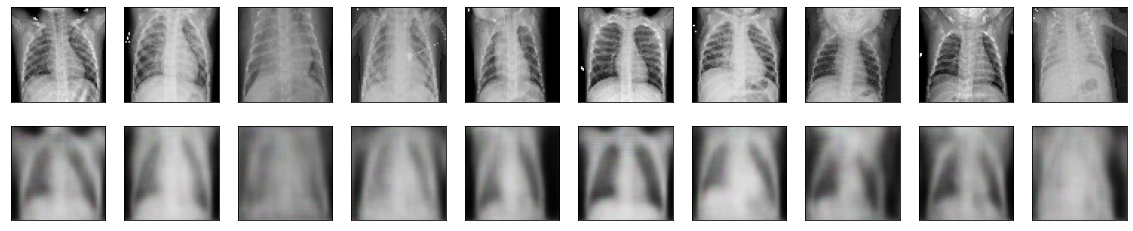

In [18]:
X_train_cnnuae = cnnuae_autoencoder.predict(X_train)
print("Shape of X_train_cnnuae:", X_train_cnnuae.shape)

X_val_cnnuae = cnnuae_autoencoder.predict(X_val)
print("Shape of X_val_cnnuae:", X_val_cnnuae.shape)

X_test_cnnuae = cnnuae_autoencoder.predict(X_test)
print("Shape of X_test_cnnuae:", X_test_cnnuae.shape)

displayer(X_train, X_train_cnnuae)

In [39]:
from tensorflow.keras.utils import plot_model
# plot the autoencoder


In [40]:
plot_model(cnnuae_autoencoder, 'autoencoder_no_compress.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
model = CNN()
model.build(input_shape=(X_train_cnnuae[0].shape))

In [30]:
X_train_cnnuae.shape

(5216, 64, 64, 3)

In [31]:
model.fit(X_train_cnnuae, y_train,validation_data=(X_val_cnnuae, y_val), epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 4s 20ms/step - loss: 0.4188 - accuracy: 0.8175 - val_loss: 1.0896 - val_accuracy: 0.5625
Epoch 2/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1761 - accuracy: 0.9335 - val_loss: 0.4925 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1484 - accuracy: 0.9425 - val_loss: 1.0127 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1264 - accuracy: 0.9534 - val_loss: 0.4392 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1265 - accuracy: 0.9530 - val_loss: 0.2422 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1130 - accuracy: 0.9584 - val_loss: 0.5317 - val_accuracy: 0.7500
Epoch 7/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1063 - accuracy: 0.9613 - val_loss: 0.2402 - val_accuracy: 0.9375

In [32]:
loss, acc = model.evaluate(X_train_cnnuae, y_train)
print("Train loss:{}, Train Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_val_cnnuae, y_val)
print("Val loss:{}, Val Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_test_cnnuae, y_test)
print("Test loss:{}, Test Accuracy:{}".format(loss, acc))

163/163 [==============================] - 1s 4ms/step - loss: 0.0788 - accuracy: 0.9693
Train loss:0.07879256457090378, Train Accuracy:0.9693251252174377
1/1 [==============================] - 0s 16ms/step - loss: 0.5380 - accuracy: 0.7500
Val loss:0.5380368232727051, Val Accuracy:0.75
20/20 [==============================] - 0s 4ms/step - loss: 1.0648 - accuracy: 0.7612
Test loss:1.0647950172424316, Test Accuracy:0.7612179517745972


# Sparse AE

In [33]:
def CNNSAE(input_shape):
    input_img = Input(shape=input_shape)
    rate = 0.000001
    x = Conv2D(32, (8, 8), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(16, (8, 8), activation='relu', padding='same', activity_regularizer=l1(rate))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (8, 8), activation='relu', padding='same', activity_regularizer=l1(rate))(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(8, (8, 8), activation='relu', padding='same', activity_regularizer=l1(rate))(encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(16, (8, 8), activation='relu', padding='same', activity_regularizer=l1(rate))(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (8, 8), activation='relu', padding='same', activity_regularizer=l1(rate))(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(3, (8, 8), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

In [34]:
cnnsae_autoencoder = CNNSAE(X_train[0].shape)

cnnsae_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        6176      
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 16)        32784     
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 16)       64  

In [35]:
cnnsae_autoencoder.fit(X_train, X_train, epochs=5, batch_size=64,
                    shuffle=True, validation_data=(X_val, X_val))

Epoch 1/5
82/82 [==============================] - 69s 829ms/step - loss: 0.0309 - val_loss: 0.0643
Epoch 2/5
82/82 [==============================] - 68s 830ms/step - loss: 0.0138 - val_loss: 0.0628
Epoch 3/5
82/82 [==============================] - 68s 830ms/step - loss: 0.0113 - val_loss: 0.0531
Epoch 4/5
82/82 [==============================] - 67s 819ms/step - loss: 0.0102 - val_loss: 0.0393
Epoch 5/5
82/82 [==============================] - 68s 834ms/step - loss: 0.0093 - val_loss: 0.0306


Shape of X_train_cnnsae: (5216, 64, 64, 3)
Shape of X_val_cnnsae: (16, 64, 64, 3)
Shape of X_test_cnnsae: (624, 64, 64, 3)


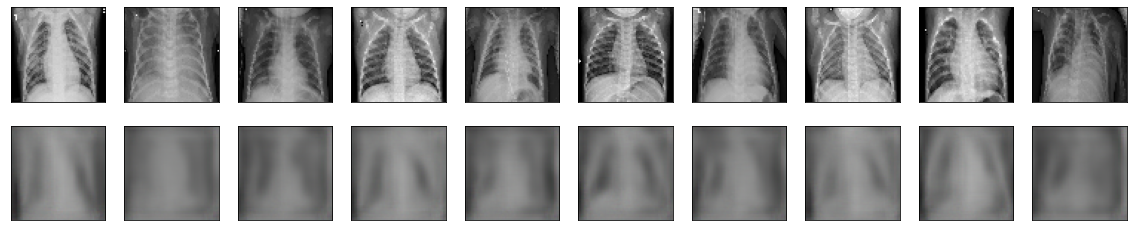

In [36]:


X_train_cnnsae = cnnsae_autoencoder.predict(X_train)
print("Shape of X_train_cnnsae:", X_train_cnnsae.shape)

X_val_cnnsae = cnnsae_autoencoder.predict(X_val)
print("Shape of X_val_cnnsae:", X_val_cnnsae.shape)

X_test_cnnsae = cnnsae_autoencoder.predict(X_test)
print("Shape of X_test_cnnsae:", X_test_cnnsae.shape)

displayer(X_train, X_train_cnnsae)

model = CNN()

model.build(input_shape=(X_train_cnnsae[0].shape))



In [37]:
model.fit(X_train_cnnsae,  y_train, validation_data=(X_val_cnnsae, y_val), epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 4s 20ms/step - loss: 0.5898 - accuracy: 0.7400 - val_loss: 0.8643 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 3s 19ms/step - loss: 0.4366 - accuracy: 0.7977 - val_loss: 0.6204 - val_accuracy: 0.7500
Epoch 3/10
163/163 [==============================] - 3s 19ms/step - loss: 0.2681 - accuracy: 0.8850 - val_loss: 0.4759 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 3s 19ms/step - loss: 0.2253 - accuracy: 0.9124 - val_loss: 0.4239 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 3s 19ms/step - loss: 0.2119 - accuracy: 0.9153 - val_loss: 0.3173 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1993 - accuracy: 0.9233 - val_loss: 0.5955 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1840 - accuracy: 0.9250 - val_loss: 0.4986 - val_accuracy: 0.6875

In [38]:
loss, acc = model.evaluate(X_train_cnnsae, y_train)
print("Train loss:{}, Train Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_val_cnnsae, y_val)
print("Val loss:{}, Val Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_test_cnnsae, y_test)
print("Test loss:{}, Test Accuracy:{}".format(loss, acc))

163/163 [==============================] - 1s 4ms/step - loss: 0.1407 - accuracy: 0.9461
Train loss:0.1406928151845932, Train Accuracy:0.9461272954940796
1/1 [==============================] - 0s 16ms/step - loss: 0.3738 - accuracy: 0.9375
Val loss:0.3738316297531128, Val Accuracy:0.9375
20/20 [==============================] - 0s 4ms/step - loss: 0.7364 - accuracy: 0.7372
Test loss:0.736383855342865, Test Accuracy:0.7371794581413269


# Denoising ae

In [39]:
noise_factor = 0.4
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_val_noisy = X_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 


X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_val_noisy = np.clip(X_val_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [40]:
denoising_autoencoder = CNNUAE(X_train_noisy[0].shape)
denoising_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 32)        6176      
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 16)        32784     
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 16)       64  

In [42]:
denoising_autoencoder.fit(X_train_noisy, X_train, epochs=5, batch_size=64,
                    shuffle=True, validation_data=(X_val_noisy, X_val))

Epoch 1/5
82/82 [==============================] - 68s 830ms/step - loss: 0.0107 - val_loss: 0.0426
Epoch 2/5
82/82 [==============================] - 68s 825ms/step - loss: 0.0081 - val_loss: 0.0219
Epoch 3/5
82/82 [==============================] - 68s 828ms/step - loss: 0.0072 - val_loss: 0.0180
Epoch 4/5
82/82 [==============================] - 68s 825ms/step - loss: 0.0067 - val_loss: 0.0136
Epoch 5/5
82/82 [==============================] - 68s 834ms/step - loss: 0.0063 - val_loss: 0.0107


Shape of X_train_denoised: (5216, 64, 64, 3)
Shape of X_val_denoised: (16, 64, 64, 3)
Shape of X_test_denoised: (624, 64, 64, 3)


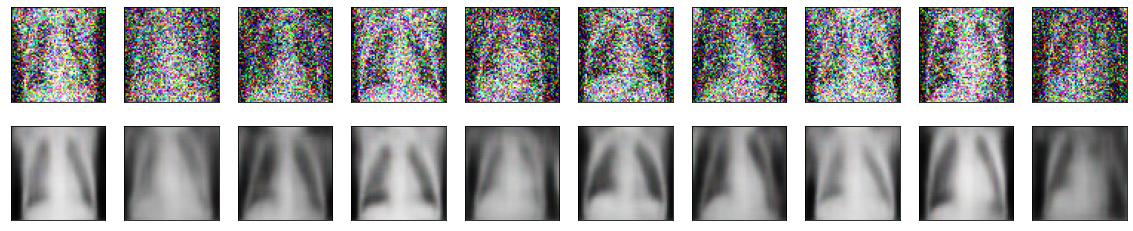

In [43]:


X_train_denoised = denoising_autoencoder.predict(X_train_noisy)
print("Shape of X_train_denoised:", X_train_denoised.shape)

X_val_denoised = denoising_autoencoder.predict(X_val_noisy)
print("Shape of X_val_denoised:", X_val_denoised.shape)

X_test_denoised = denoising_autoencoder.predict(X_test_noisy)
print("Shape of X_test_denoised:", X_test_denoised.shape)

displayer(X_train_noisy, X_train_denoised)

model = CNN()

model.build(input_shape=(X_train_denoised[0].shape))

In [44]:
model.fit(X_train_denoised,  y_train, validation_data=(X_val_denoised, y_val), epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 4s 20ms/step - loss: 0.4249 - accuracy: 0.8104 - val_loss: 0.6477 - val_accuracy: 0.7500
Epoch 2/10
163/163 [==============================] - 3s 19ms/step - loss: 0.2055 - accuracy: 0.9185 - val_loss: 0.7188 - val_accuracy: 0.6250
Epoch 3/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1788 - accuracy: 0.9321 - val_loss: 0.9386 - val_accuracy: 0.6250
Epoch 4/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1536 - accuracy: 0.9408 - val_loss: 0.4889 - val_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1516 - accuracy: 0.9427 - val_loss: 0.4802 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1361 - accuracy: 0.9477 - val_loss: 0.3823 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 3s 19ms/step - loss: 0.1282 - accuracy: 0.9507 - val_loss: 0.6309 - val_accuracy: 0.8125

In [47]:
loss, acc = model.evaluate(X_train_denoised, y_train)
print("Train loss:{}, Train Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_val_denoised, y_val)
print("Val loss:{}, Val Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_test_denoised, y_test)
print("Test loss:{}, Test Accuracy:{}".format(loss, acc))

163/163 [==============================] - 1s 4ms/step - loss: 0.1050 - accuracy: 0.9607
Train loss:0.10503366589546204, Train Accuracy:0.9606978297233582
1/1 [==============================] - 0s 16ms/step - loss: 0.5420 - accuracy: 0.8750
Val loss:0.5419756174087524, Val Accuracy:0.875
20/20 [==============================] - 0s 4ms/step - loss: 0.7584 - accuracy: 0.7612
Test loss:0.7583697438240051, Test Accuracy:0.7612179517745972


# VAE

In [48]:
#Create a sampling layer
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#Encoder
def encoder():
    latent_dim = 2 ############ HB
    img_size = 64
    num_channels = 3
    encoder_inputs = Input(shape=(img_size, img_size, num_channels))
    x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = Flatten()(x)
    x = Dense(16, activation="relu")(x)
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

#Decoder
def decoder():
    latent_dim = 2
    #latent_inputs = Input(shape=(latent_dim,))   ############ HB
    latent_inputs = Input(shape=latent_dim)       ############ HB
    x = Dense(16 * 16 * 64, activation="relu")(latent_inputs)
    x = Reshape((16, 16, 64))(x)
    x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder


In [49]:
#Custom VAE
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(binary_crossentropy(data, reconstruction), axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [50]:
latent_dim = 2
enc = encoder()
dec = decoder()
enc.summary()
dec.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_33 (Conv2D)             (None, 32, 32, 32)   896         ['input_4[0][0]']                
                                                                                                  
 conv2d_34 (Conv2D)             (None, 16, 16, 64)   18496       ['conv2d_33[0][0]']              
                                                                                                  
 flatten_4 (Flatten)            (None, 16384)        0           ['conv2d_34[0][0]']              
                                                                                            

In [51]:
vae = VAE(enc, dec)
vae.compile(optimizer='adam')

In [52]:
train = np.concatenate([X_train, X_val], axis=0)
print("Shape of train:", train.shape)

Shape of train: (5232, 64, 64, 3)


In [59]:
vae.fit(train, epochs=2, batch_size=32)

Epoch 1/2
164/164 [==============================] - 4s 26ms/step - loss: 2543.0139 - reconstruction_loss: 2543.0073 - kl_loss: 0.0371
Epoch 2/2
164/164 [==============================] - 4s 26ms/step - loss: 2540.0868 - reconstruction_loss: 2542.0117 - kl_loss: 0.0401


Shape of X_train_vae: (5216, 64, 64, 3)
---------------------------------------
Shape of X_val_vae: (16, 64, 64, 3)
---------------------------------------
Shape of X_test_vae: (624, 64, 64, 3)
---------------------------------------


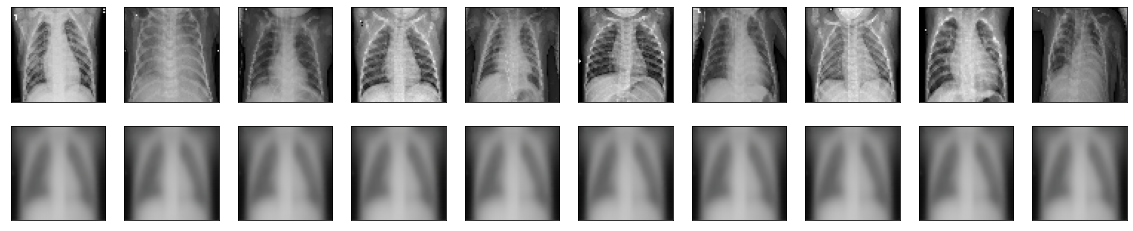

In [60]:
def get_vae_data(vae, X):
    z_mean, z_log_var, z = vae.encoder.predict(X)
    X_vae = vae.decoder.predict(z)
    return X_vae

X_train_vae = get_vae_data(vae, X_train)
print("Shape of X_train_vae:", X_train_vae.shape)
print("---------------------------------------")

X_val_vae = get_vae_data(vae, X_val)
print("Shape of X_val_vae:", X_val_vae.shape)
print("---------------------------------------")

X_test_vae = get_vae_data(vae, X_test)
print("Shape of X_test_vae:", X_test_vae.shape)
print("---------------------------------------")

displayer(X_train, X_train_vae)

In [61]:
model = CNN()

model.build(input_shape=(X_train_vae[0].shape))

In [62]:
model.fit(X_train_vae,  y_train, validation_data=(X_val_vae, y_val), epochs=10, batch_size=32)

Epoch 1/10
163/163 [==============================] - 4s 20ms/step - loss: 0.5851 - accuracy: 0.7412 - val_loss: 0.8161 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 3s 19ms/step - loss: 0.5784 - accuracy: 0.7429 - val_loss: 0.7517 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 3s 19ms/step - loss: 0.5754 - accuracy: 0.7429 - val_loss: 0.8208 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 3s 19ms/step - loss: 0.5733 - accuracy: 0.7429 - val_loss: 0.7874 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 3s 19ms/step - loss: 0.5724 - accuracy: 0.7429 - val_loss: 0.8168 - val_accuracy: 0.5000
Epoch 6/10
163/163 [==============================] - 3s 19ms/step - loss: 0.5753 - accuracy: 0.7429 - val_loss: 0.8060 - val_accuracy: 0.5000
Epoch 7/10
163/163 [==============================] - 3s 19ms/step - loss: 0.5752 - accuracy: 0.7429 - val_loss: 0.8090 - val_accuracy: 0.5000

In [63]:
loss, acc = model.evaluate(X_train_vae, y_train)
print("Train loss:{}, Train Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_val_vae, y_val)
print("Val loss:{}, Val Accuracy:{}".format(loss, acc))

loss, acc = model.evaluate(X_test_vae, y_test)
print("Test loss:{}, Test Accuracy:{}".format(loss, acc))

163/163 [==============================] - 1s 4ms/step - loss: 0.5702 - accuracy: 0.7429
Train loss:0.5701696276664734, Train Accuracy:0.7429064512252808
1/1 [==============================] - 0s 17ms/step - loss: 0.8383 - accuracy: 0.5000
Val loss:0.8383389115333557, Val Accuracy:0.5
20/20 [==============================] - 0s 4ms/step - loss: 0.7003 - accuracy: 0.6250
Test loss:0.7003366351127625, Test Accuracy:0.625


# References
* https://keras.io/examples/generative/vae/
* https://medium.com/@debanjandatta/deep-contractive-auto-encoder-in-keras-aa074d839eb6
* https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368
* https://machinelearningmastery.com/how-to-reduce-generalization-error-in-deep-neural-networks-with-activity-regularization-in-keras/
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://github.com/wiseodd/hipsternet
* https://github.com/keras-team/keras/blob/2.1.1/examples/variational_autoencoder.py